In [38]:
import requests
from bs4 import BeautifulSoup
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

In [6]:
min_price = 1000
max_price = 1600

headers={"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"}

df = None

for page_number in range(1, 6):
    url = f"https://www.realtor.com/apartments/Greenville_SC/pg-{page_number}"

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    properties = soup.find_all('div', attrs={'class': "BasePropertyCard_propertyCardWrap__pblQC"})

    property_df = get_property_df(properties)
    if df is None:
        df = property_df
    else:
        df = pd.concat((df, property_df))

    print(page_number)

1
2
3
4
5


In [2]:
def format_baths(baths_str):

    if '-' in baths_str:
        left, right = baths_str.split(' - ')
        return format_baths(left) + ' - ' + format_baths(right)

    return re.findall(r'\d+', baths_str)[0]

In [3]:
def format_beds(beds_str):

    if '-' in beds_str:
        left, right = beds_str.split(' - ')
        return format_beds(left) + ' - ' + format_beds(right)

    if beds_str == 'Studio':
        return '0'

    return re.findall(r'\d+', beds_str)[0]

In [4]:
def get_property_df(properties):

    property_data = {
        'buy_type': [],
        'desc': [],
        'address': [],
        'price': [],
        'beds': [],
        'baths': [],
        'sqft': [],
        'pets': []
    }

    for property in properties:

        try:
            prop_description = property.find_all('div', attrs={'data-testid': 'card-description'})[0].text
            
            rent_or_sale = prop_description.split(' ')[1].lower()
            house_or_apartment = prop_description.split(' ')[3].lower()

            price = property.find_all('div', attrs={'data-testid': 'card-price'})[0].text

            address_line_1 = property.find_all('div', attrs={'data-testid': 'card-address-1'})[0].text
            address_line_2 = property.find_all('div', attrs={'data-testid': 'card-address-2'})[0].text
            address = address_line_1 + ', ' + address_line_2

            beds = property.find_all('li', attrs={'data-testid': 'property-meta-beds'})
            if len(beds) == 0:
                beds = 'nan'
            else:
                beds = format_beds(beds[0].text)
            
            baths = property.find_all('li', attrs={'data-testid': 'property-meta-baths'})
            if len(baths) == 0:
                baths = 'nan'
            else:
                baths = format_baths(baths[0].text)

            sqft = property.find_all('li', attrs={'data-testid': 'property-meta-sqft'})
            if len(sqft) == 0:
                sqft = 'nan'
            else:
                sqft = sqft[0].text
                sqft = sqft.split('sqft')[0]

            pets = property.find_all('li', attrs={'data-testid': 'property-meta-pet'})
            if len(pets) == 0:
                pets = 'nan'
            else:
                pets = pets[0].text
                pets = pets.split('OK')[0]
                pets = pets.lower()
                if pets == 'pets':
                    pets = 'all pets'

            property_data['buy_type'].append(rent_or_sale)
            property_data['desc'].append(house_or_apartment)
            property_data['address'].append(address)
            property_data['price'].append(price)
            property_data['beds'].append(beds)
            property_data['baths'].append(baths)
            property_data['sqft'].append(sqft)
            property_data['pets'].append(pets)

        except IndexError:
            continue

    return pd.DataFrame(property_data)

In [5]:
def format_min_and_max(value):
    value = value.replace('$', '')
    value = value.replace(',', '')

    if ' - ' in value:
        return value.split(' - ')
    
    return value, value

In [7]:
min_and_max_columns = ['price', 'beds', 'baths', 'sqft']

for col in min_and_max_columns:
    df[[f'min_{col}', f'max_{col}']] = df.apply(lambda x: format_min_and_max(x[col]), axis=1, result_type='expand')

df.drop(columns=min_and_max_columns, inplace=True)

In [8]:
df.reset_index(inplace=True, drop=True)

df

,buy_type,desc,address,pets,min_price,max_price,min_beds,max_beds,min_baths,max_baths,min_sqft,max_sqft
0,rent,house,"601 Cleveland St Apt 12D, Greenville, SC 29601",cats,1350,1350,1,1,1,1,nan,nan
1,rent,house,"105 McCall St Unit A, Greenville, SC 29601",all pets,4200,4200,4,4,3,3,2600,2600
2,rent,apartment,"1600 Azalea Hill Dr, Greenville, SC 29607",all pets,1119,1600,0,2,1,2,450,1100
3,rent,apartment,"98 E McBee Ave, Greenville, SC 29601",all pets,1647,3437,0,2,1,2,774,1264
4,rent,house,"418 Pollyanna Dr, Greenville, SC 29605",all pets,1950,1950,3,3,2,2,1951,1951
...,...,...,...,...,...,...,...,...,...,...,...,...
205,rent,house,"101 Lanewood Dr, Greenville, SC 29607",nan,1600,1600,3,3,2,2,nan,nan
206,rent,house,"1024 N Franklin Rd, Greenville, SC 29617",nan,1295,1295,2,2,1,1,1272,1272
207,rent,condo,"433 McKenna Cir Unit 433, Greenville, SC 29615",nan,1295,1295,3,3,2,2,1296,1296
208,rent,house,"101 Sharon Dr, Greenville, SC 29617",all pets,1650,1650,4,4,2,2,1430,1430


In [9]:
df[['min_price', 'max_price', 'min_beds', 'max_beds', 'min_baths', 'max_baths', 'min_sqft', 'max_sqft']] = df[['min_price', 'max_price', 'min_beds', 'max_beds', 'min_baths', 'max_baths', 'min_sqft', 'max_sqft']].astype('float')


In [10]:
df

,buy_type,desc,address,pets,min_price,max_price,min_beds,max_beds,min_baths,max_baths,min_sqft,max_sqft
0,rent,house,"601 Cleveland St Apt 12D, Greenville, SC 29601",cats,1350.0,1350.0,1.0,1.0,1.0,1.0,NaN,NaN
1,rent,house,"105 McCall St Unit A, Greenville, SC 29601",all pets,4200.0,4200.0,4.0,4.0,3.0,3.0,2600.0,2600.0
2,rent,apartment,"1600 Azalea Hill Dr, Greenville, SC 29607",all pets,1119.0,1600.0,0.0,2.0,1.0,2.0,450.0,1100.0
3,rent,apartment,"98 E McBee Ave, Greenville, SC 29601",all pets,1647.0,3437.0,0.0,2.0,1.0,2.0,774.0,1264.0
4,rent,house,"418 Pollyanna Dr, Greenville, SC 29605",all pets,1950.0,1950.0,3.0,3.0,2.0,2.0,1951.0,1951.0
...,...,...,...,...,...,...,...,...,...,...,...,...
205,rent,house,"101 Lanewood Dr, Greenville, SC 29607",nan,1600.0,1600.0,3.0,3.0,2.0,2.0,NaN,NaN
206,rent,house,"1024 N Franklin Rd, Greenville, SC 29617",nan,1295.0,1295.0,2.0,2.0,1.0,1.0,1272.0,1272.0
207,rent,condo,"433 McKenna Cir Unit 433, Greenville, SC 29615",nan,1295.0,1295.0,3.0,3.0,2.0,2.0,1296.0,1296.0
208,rent,house,"101 Sharon Dr, Greenville, SC 29617",all pets,1650.0,1650.0,4.0,4.0,2.0,2.0,1430.0,1430.0


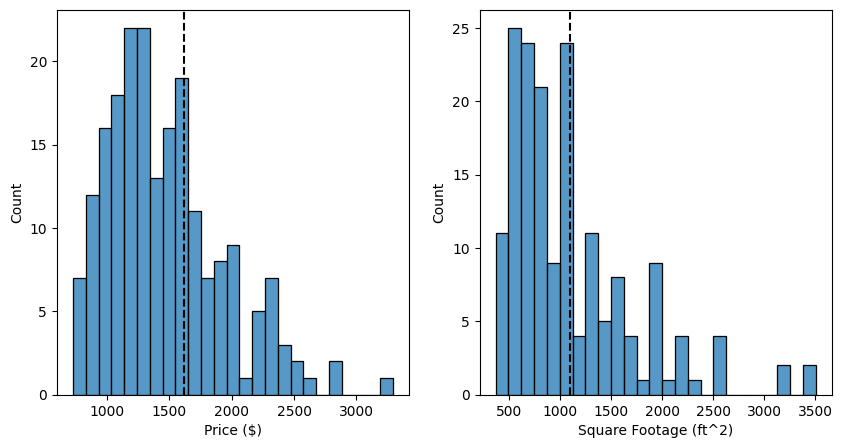

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.histplot(x='min_price', data=df[df['min_price'] < 4000], bins=25, ax=axs[0])
axs[0].axvline(df['min_price'].mean(), linestyle='--', color='k')
axs[0].set_xlabel('Price ($)')

sns.histplot(x='min_sqft', data=df, bins=25, ax=axs[1])
axs[1].axvline(df['min_sqft'].mean(), linestyle='--', color='k')
axs[1].set_xlabel('Square Footage (ft^2)')
plt.show()

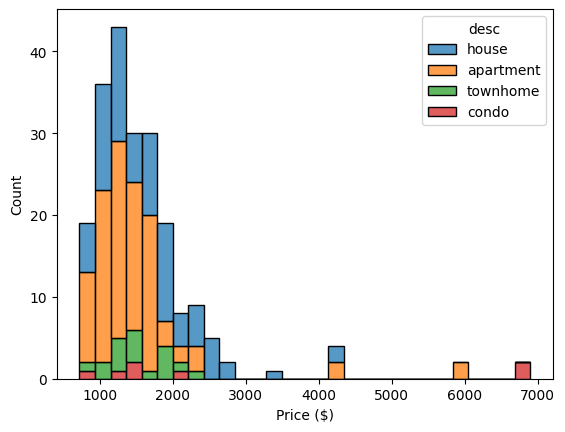

In [77]:
sns.histplot(x='min_price', data=df, hue='desc', multiple='stack')

plt.xlabel('Price ($)')
plt.show()

/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


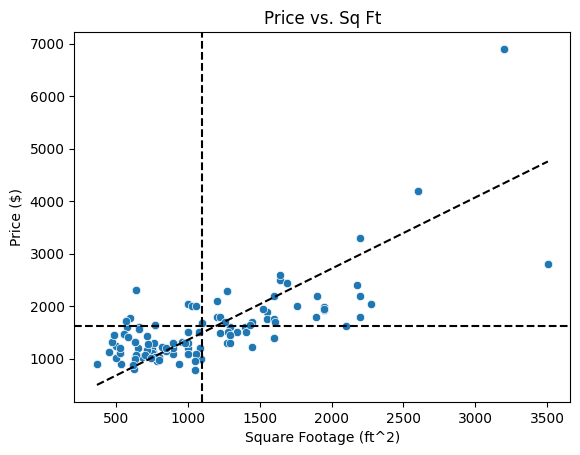

In [62]:
sns.scatterplot(x='min_sqft', y='min_price', data=df)

plt.axvline(df['min_sqft'].mean(), linestyle='--', color='k')
plt.axhline(df['min_price'].mean(), linestyle='--', color='k')

lm = LinearRegression(fit_intercept=False)
no_na = df.dropna()
X = no_na[['min_sqft']]
y = no_na[['min_price']]
lm.fit(X, y)

xs = np.linspace(df.min_sqft.min(), df.min_sqft.max()).reshape(-1, 1)
plt.plot(xs, lm.predict(xs), linestyle='--', color='k')

plt.xlabel('Square Footage (ft^2)')
plt.ylabel('Price ($)')
plt.title('Price vs. Sq Ft')
plt.show()

In [63]:
# Over-performers -- Big and Cheap
df[(df.min_sqft > df.min_sqft.mean()) & (df.min_price < df.min_price.mean())].sort_values(by='min_price')

,buy_type,desc,address,pets,min_price,max_price,min_beds,max_beds,min_baths,max_baths,min_sqft,max_sqft
123,rent,apartment,"110 Prospect St Unit 1, Greenville, SC 29611",all pets,1225.0,1225.0,3.0,3.0,1.0,1.0,1450.0,1450.0
206,rent,house,"1024 N Franklin Rd, Greenville, SC 29617",nan,1295.0,1295.0,2.0,2.0,1.0,1.0,1272.0,1272.0
207,rent,condo,"433 McKenna Cir Unit 433, Greenville, SC 29615",nan,1295.0,1295.0,3.0,3.0,2.0,2.0,1296.0,1296.0
165,rent,apartment,"15 Backwater Way, Greenville, SC 29611",nan,1400.0,1400.0,4.0,4.0,2.0,2.0,1600.0,1600.0
192,rent,apartment,"15 Backwater Way, Greenville, SC 29611",nan,1400.0,1400.0,4.0,4.0,2.0,2.0,1600.0,1600.0
162,rent,apartment,"2808 E North St, Greenville, SC 29615",nan,1450.0,1450.0,2.0,2.0,1.0,1.0,1292.0,1292.0
189,rent,apartment,"2808 E North St, Greenville, SC 29615",nan,1450.0,1450.0,2.0,2.0,1.0,1.0,1292.0,1292.0
185,rent,townhome,"40 Wood Pointe Dr Apt 83, Greenville, SC 29615",all pets,1495.0,1495.0,2.0,2.0,2.0,2.0,1224.0,1224.0
64,rent,house,"20 Clearfield Rd, Greenville, SC 29607",nan,1500.0,1500.0,3.0,3.0,2.0,2.0,1407.0,1407.0
174,rent,townhome,"520 Hampton Townes Dr, Greenville, SC 29617",all pets,1500.0,1500.0,3.0,3.0,2.0,2.0,1280.0,1280.0
